# Downloading and exploring MNIST

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Label: 5


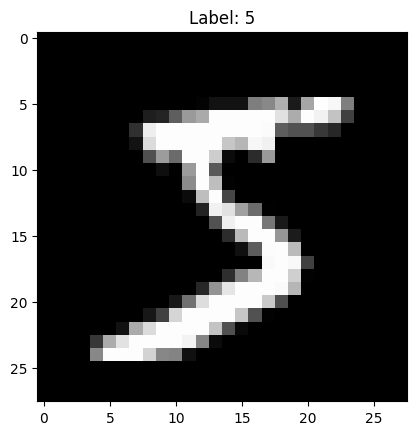

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt

transform= transforms.ToTensor()  # without converting images to tensors, our model wont understand images mathematically

train_data= datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data= datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

image, label= train_data[0]
print(f"Image shape: {image.shape}")  # (1, 28, 28) - 1 channel, 28x28 pixels
print(f"Label: {label}")

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()



# Creating dataloaders

In [2]:
train_set, val_set= random_split(train_data,[50000,10000])



train_loader= DataLoader(train_set, batch_size=64, shuffle=True)
val_loader= DataLoader(val_set,batch_size=64,shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Batches in train: {len(train_loader)}")
print(f"Batches in test: {len(test_loader)}")
print(f"Batches in val: {len(val_loader)}")

images, labels = next(iter(train_loader))
print(f"Batch images shape: {images.shape}")  # (64, 1, 28, 28) (batch, channel_dim, height,width )
print(f"Batch labels shape: {labels.shape}")

Batches in train: 782
Batches in test: 157
Batches in val: 157
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


# Building the network

In [3]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten= nn.Flatten() # Flatten 28x28 image to 784 vector

        self.layer1= nn.Linear(784, 128)
        self.relu1= nn.ReLU()
        self.layer2= nn.Linear(128,64)
        self.relu2= nn.ReLU()
        self.layer3= nn.Linear(64,10)

    def forward(self, x):
        x= self.flatten(x)
        x= self.relu1(self.layer1(x))
        x= self.relu2(self.layer2(x))
        x= self.layer3(x)
        return x
    

model= DigitClassifier()
print(model)

DigitClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=64, out_features=10, bias=True)
)


# Training Loop

In [4]:
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs= 5

best_loss= float("inf")

for epoch in range(num_epochs):
    model.train()
    running_loss= 0 

    for batch_idx, (images,labels) in enumerate(train_loader):
        output= model(images)
        loss= criterion(output, labels) # fits into log loss as loss = -log(ptrue)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx+1)%100==0:
            print(f'epoch [{epoch+1}/{num_epochs}], batch {(batch_idx+1)}/{len(train_loader)}, loss: {loss.item()}')

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss}\n")


    model.eval()
    val_running_loss= 0
    with torch.no_grad():
        for val_images,val_labels in val_loader:
            val_output= model(val_images)
            val_loss = criterion(val_output,val_labels)
            val_running_loss += val_loss.item()

        avg_val_loss= val_running_loss/len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Val Loss: {avg_val_loss:.4f}\n")


    if avg_val_loss < best_loss:
        best_loss= avg_val_loss
        torch.save(model.state_dict(), "final_model.pth")

epoch [1/5], batch 100/782, loss: 0.5626494884490967
epoch [1/5], batch 200/782, loss: 0.3690962493419647
epoch [1/5], batch 300/782, loss: 0.377603143453598
epoch [1/5], batch 400/782, loss: 0.25901174545288086
epoch [1/5], batch 500/782, loss: 0.17747019231319427
epoch [1/5], batch 600/782, loss: 0.2023686170578003
epoch [1/5], batch 700/782, loss: 0.4157658815383911
Epoch [1/5] completed. Average Loss: 0.3754296689854025

Epoch [1/5] Average Val Loss: 0.2026

epoch [2/5], batch 100/782, loss: 0.260833203792572
epoch [2/5], batch 200/782, loss: 0.08724246919155121
epoch [2/5], batch 300/782, loss: 0.11043247580528259
epoch [2/5], batch 400/782, loss: 0.12170633673667908
epoch [2/5], batch 500/782, loss: 0.2113320678472519
epoch [2/5], batch 600/782, loss: 0.05531398206949234
epoch [2/5], batch 700/782, loss: 0.1487816572189331
Epoch [2/5] completed. Average Loss: 0.1554230644041315

Epoch [2/5] Average Val Loss: 0.1446

epoch [3/5], batch 100/782, loss: 0.18609067797660828
epoch [3/5

# Accuracy evaluation

In [5]:
model.load_state_dict(torch.load("final_model.pth"))

model.eval()
correct=0
total=0

with torch.no_grad():
    for images,labels in test_loader:
        outputs= model(images)
        _, predicted= torch.max(outputs,1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


/tmp/ipykernel_35275/3991448907.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("final_model.pth"))


Test Accuracy: 97.21%


# Testing on individual images

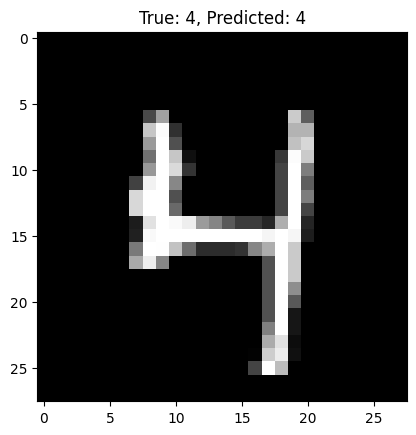

In [6]:
import random

model.eval()
idx= random.randint(0, len(test_data)-1)
image, true_label = test_data[idx]

with torch.no_grad():
    output= model(image.unsqueeze(0))
    _,predicted= torch.max(output, 1)

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"True: {true_label}, Predicted: {predicted.item()}")
plt.show()



# Finding classification mistakes

29 amongst 1000 images


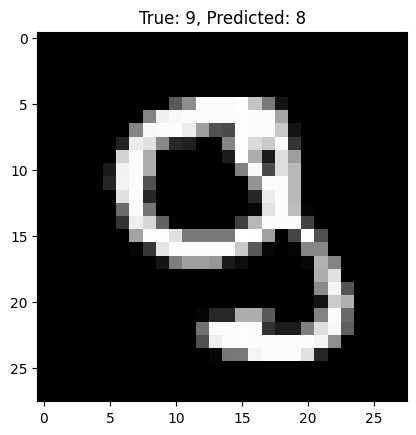

In [8]:
model.eval()
mistakes=[]

with torch.no_grad():
    for idx in range(1000):

        image, true_label= test_data[idx]
        output= model(image.unsqueeze(0))

        _, predicted= torch.max(output, 1)

        if predicted.item() != true_label :
            mistakes.append((idx,predicted,true_label))
    
    print(f'{len(mistakes)} amongst 1000 images')

idx, predicted, true_label= mistakes[1]
image, _ = test_data[idx]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"True: {true_label}, Predicted: {predicted.item()}")
plt.show()